# Konstrukcija nasumičnog Voronoi uzorka
Konstruiramo točke u 2D koje ćemo odijeliti u Voronoi ćelije.
Točke generiramo pomoću normalne distribucije u 2D (nezavisne)
Naredbom np.c_ slažemo x i y setove koordinata u jednu matricu dimenzija 2xN, a transponiranjem dobivamo oblik koji traži Voronoi (Nx2)

In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
N = 1000
x = np.random.normal(0,100,N)
y = np.random.normal(0,100,N)
X = np.c_[[x,y]].T


Kreiramo instancu klase Voronoi.

Plot vršimo naredbom voronoi_plot_2d koja automatski prikazuje točke u prostoru zajedno s pripadnim poligonima.
 
Vrhovi poligona zovu se verteksi

Gustoću računamo tako da uzmemo sve indekse verteksa koji pripadaju određenom poligonu 

i izračunamo površinu samo za te vertekse i invertiramo

Moguće je da se dogodi da poligon ima površinu nula (npr. trokut kojemu su 2 točke identične)

Njih isključujemo tako da prvo pronađemo koji su poligoni beskonačne gustoće naredbom np.isinf()

Zanimaju nas samo oni koji imaju konačnu gustoću, odnosno negacija isinf, što postižemo koristeći ~np.isinf()

Histogram možemo konstruirati nakon izuzimanja poligona beskonačne gustoće

Budući da se radi o logaritmu gustoće, svaka normalna distribucija log(n) je zapravo log-normalna distribucija


# Izračun gustoće

/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


normalnost KstestResult(statistic=0.10905437143349689, pvalue=8.206771777003445e-11)


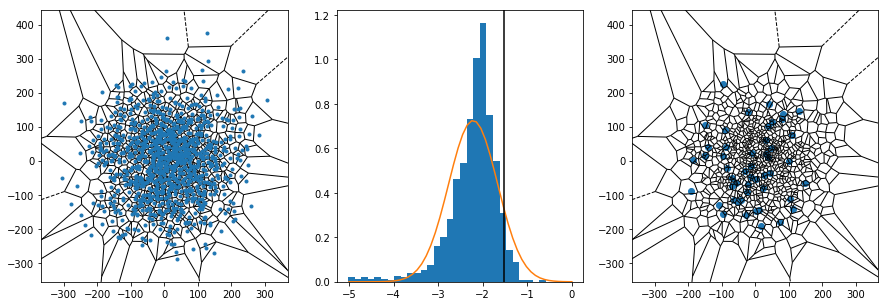

In [133]:
def area(x,y):
    # Površina poligona uz dane x i y koordinate
    return np.abs(np.dot(y,np.roll(x,1))-np.dot(x,np.roll(y,1)))/2.
vor = Voronoi(X)
f,ax=plt.subplots(1,3,figsize=(15,5))
voronoi_plot_2d(vor,ax=ax[0],show_vertices=False);
A = np.array([1/area(vor.vertices[k,0],vor.vertices[k,1]) for k in vor.regions])
lgn = np.log10(A[~np.isinf(A)])
ax[1].hist(lgn,30,normed=True);
print("normalnost",sc.kstest(lgn,sc.norm(*sc.norm.fit(lgn)).cdf))
ax[1].plot(np.linspace(-5,0),sc.norm(*sc.norm.fit(lgn)).pdf(np.linspace(-5,0)),label="normalna")
ax[1].axvline(np.percentile(lgn,95),color="k")

voronoi_plot_2d(vor,show_points=False,show_vertices=False,ax=ax[2])
vor2=Voronoi(vor.points[lgn>np.percentile(lgn,95)])
ax[2].scatter(*vor2.points.T);


# Prosječna udaljenost među točkama i potraga za susjednim clusterima KDTree metodom
Sada se možemo pitati kolika je prosječna udaljenost među točkama. Crvenom bojom je označena voronoi teselacija clustera

Text(0.5,1,'Broj susjeda clustera \nunutar 5. percentila distribucije udaljenosti')

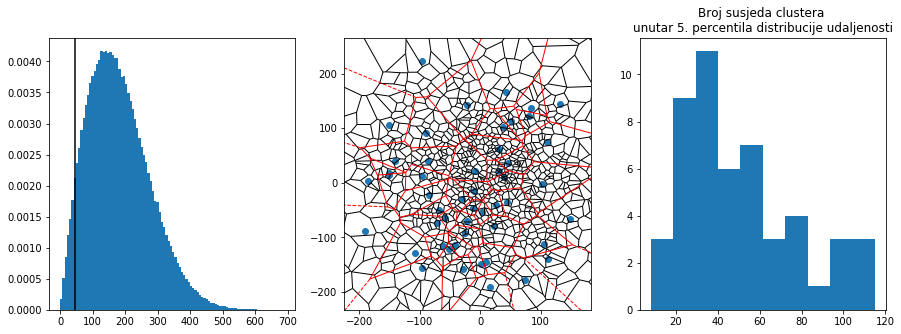

In [135]:
X, Xt=np.meshgrid(x,x)
Y, Yt=np.meshgrid(y,y)
D = np.sqrt((X-Xt)**2+(Y-Yt)**2) # Matrica udaljenosti
D = D[np.triu_indices(D.shape[0],1)] # Uzimamo samo gornji trokut,bez dijagonale
f, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(D,100,normed=True)  
ax[0].axvline(np.percentile(D,5),color="k")
voronoi_plot_2d(vor,show_points=False,show_vertices=False,ax=ax[1])
ax[1].scatter(*vor.points[lgn>np.percentile(lgn,95)].T);
voronoi_plot_2d(vor2,show_points=False,show_vertices=False,ax=ax[1],line_colors="r")
KD=KDTree(vor.points)
l = []
for i in vor.points[lgn>np.percentile(lgn,95)]:
    l.append(KD.count_neighbors(KDTree([i]),np.percentile(D,5)))
ax[2].hist(l)
ax[2].set_title("Broj susjeda clustera \nunutar 5. percentila distribucije udaljenosti")

# Klasifikacija temeljena na Voronoi teselaciji
Kao kompliciraniji primjer, dan je uzorak od 4 clustera + šum. 
Voronoi teselacijom je određeno koje točke pripadaju kojem clusteru, kojima su središte određena k-srednjim vrijednostima.

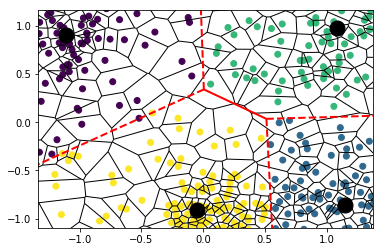

In [11]:
from scipy.cluster import vq
N = 100
Nsum = 5
noise = np.random.uniform(-6,6,2*N).reshape(-1,2)
X_1 = np.random.multivariate_normal([0,-5],[[1,0],[0,1]],size=N)
X_2 = np.random.multivariate_normal([5,5],[[4,0],[0,4]],size=N)
X_3 = np.random.multivariate_normal([-5,5],[[4,1],[1,4]],size=N)
X_4 = np.random.multivariate_normal([5,-5],[[4,0],[0,4]],size=N)
X   = np.concatenate((X_1,X_2,X_3,X_4,noise))
Z   = vq.whiten(X)
clusters,distortion = vq.kmeans(Z,4)
Vor = Voronoi(Z)
Vor_cluster = Voronoi(clusters)
c   = [np.argmin([np.sqrt((z[0]-p[0])**2+(z[1]-p[1])**2) for p in clusters]) for z in Z]
f,ax=plt.subplots(1,1)
voronoi_plot_2d(Vor,ax=ax, show_vertices=False,show_points=False)
voronoi_plot_2d(Vor_cluster,ax=ax, show_vertices=False,show_points=False,line_colors="r",line_width=2)
ax.scatter(Z[:,0],Z[:,1],c=c)
ax.scatter(clusters[:,0],clusters[:,1],s=15**2,c="k");
